# Binary classification - per_question_model using Naive Bayes(sultan)

# Importing and Preprocessing

## Importing libraries

In [1]:
#### import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from modAL.models import ActiveLearner
from modAL.models import ActiveLearner

import en_core_web_sm
nlp = en_core_web_sm.load()

%matplotlib inline

In [2]:
df = pd.read_pickle("./sultan_features.pkl")
df = df.fillna(0)
short_df = df[['question_id','question','student_answer','student_modified','ref_modified', \
               'grade','length_ratio','aligned_score','aligned_score_demo','cos_similarity','cos_similarity_demo']]
short_df['status'] = short_df['grade'] >= 3
short_df['status'] = short_df['status'].astype(int)

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Bag of words per question model

In [3]:
ques_id_list = list(short_df['question_id'].unique())
Accuracy_dict = {}
accuracy_list = []

n = 0

while  ques_id_list :
    print("question id:",ques_id_list[0])
    # FOR ONE BY ONE QUESTION
    ques_df = short_df[short_df['question_id'] == ques_id_list[0]]
    ques_df.reset_index(drop = True,inplace=True)
    

    # counting unique words in every student's answer
    CV = CountVectorizer()
    student_answer_count_vector = CV.fit_transform(ques_df['student_modified'])
    student_answer_count_vector = student_answer_count_vector.toarray()

    X = student_answer_count_vector
    Y = ques_df['status'].values

    #getting the seed index
    classes = ques_df['status'].unique()
    seed_index = []
    for i in classes:
        seed_index.append(ques_df['status'][ques_df['status']==i].index[0])
    print(seed_index)

    act_data = ques_df.copy()
#     accuracy_list = []

    # initialising
    train_idx = seed_index
    X_train = X[train_idx]
    y_train = Y[train_idx]

    # generating the pool
    X_pool = np.delete(X, train_idx, axis=0)
    y_pool = np.delete(Y, train_idx)

    act_data = act_data.drop(axis=0,index = train_idx)
    act_data.reset_index(drop = True,inplace=True)


    # initializing the active learner
    # lr = LogisticRegression()
    nb = MultinomialNB()
    learner = ActiveLearner(
    #     estimator = lr,
        estimator = nb,
    #     estimator = RandomForestClassifier(n_estimators=5),
    #     estimator=KNeighborsClassifier(n_neighbors=3),
        X_training=X_train, y_training=y_train
    )

    # pool-based sampling
    n_queries = math.ceil(len(ques_df)/10.0)
    print (n_queries)
    for idx in range(n_queries):
        query_idx, query_instance = learner.query(X_pool)
#         print("Question number: ", ques_id_list[0])
#         print("\nQ: ", act_data.loc[int(query_idx),'question'])
#         print("A: ",act_data.loc[int(query_idx),'student_answer'])
#         print("Actual grade: ",y_pool[query_idx].reshape(1, ))
#     #     print(learner.sigma_)
#         print ("Class probabilities: ",learner.predict_proba(X_pool[query_idx].reshape(1, -1)))
#         human_label = int(input("\nGive me a grade 0 or 1:"))
        learner.teach(
            X=X_pool[query_idx].reshape(1, -1),
            y=y_pool[query_idx].reshape(1, )
        )

        # remove queried instance from pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)

        act_data = act_data.drop(axis=0,index = query_idx)
        act_data.reset_index(drop=True, inplace=True)

#         accuracy_list.append(learner.score(X,Y))
#         print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X, Y)))
    accuracy_list.append(learner.score(X_pool, y_pool))
    Accuracy_dict[ques_id_list[0]] = accuracy_list
    print("By just labelling 10 % of total data accuracy of ", round(learner.score(X_pool, y_pool),2), "% is achieved on the unseen data"  )
    ques_id_list.pop(0)
    n += 1

question id: 1.1
[0, 5]
3
By just labelling 10 % of total data accuracy of  0.71 % is achieved on the unseen data
question id: 1.2
[0, 5]
3
By just labelling 10 % of total data accuracy of  0.75 % is achieved on the unseen data
question id: 1.3
[0, 3]
3
By just labelling 10 % of total data accuracy of  0.83 % is achieved on the unseen data
question id: 1.4
[0, 7]
3
By just labelling 10 % of total data accuracy of  0.96 % is achieved on the unseen data
question id: 1.5
[0, 1]
3
By just labelling 10 % of total data accuracy of  0.96 % is achieved on the unseen data
question id: 1.6
[0, 1]
3
By just labelling 10 % of total data accuracy of  0.42 % is achieved on the unseen data
question id: 1.7
[0, 25]
3
By just labelling 10 % of total data accuracy of  1.0 % is achieved on the unseen data
question id: 2.1
[0, 1]
3
By just labelling 10 % of total data accuracy of  0.88 % is achieved on the unseen data
question id: 2.2
[0, 1]
3
By just labelling 10 % of total data accuracy of  0.92 % is ac

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -


[0, 1]
4
By just labelling 10 % of total data accuracy of  1.0 % is achieved on the unseen data
question id: 3.7
[0, 1]
4
By just labelling 10 % of total data accuracy of  0.96 % is achieved on the unseen data
question id: 4.1
[0, 7]
3
By just labelling 10 % of total data accuracy of  0.88 % is achieved on the unseen data
question id: 4.2
[0, 1]
3
By just labelling 10 % of total data accuracy of  0.68 % is achieved on the unseen data
question id: 4.3
[0, 16]
3
By just labelling 10 % of total data accuracy of  1.0 % is achieved on the unseen data
question id: 4.4
[0, 24]
3
By just labelling 10 % of total data accuracy of  0.96 % is achieved on the unseen data
question id: 4.5
[0, 1]
3
By just labelling 10 % of total data accuracy of  0.64 % is achieved on the unseen data
question id: 4.6
[0, 2]
3
By just labelling 10 % of total data accuracy of  0.92 % is achieved on the unseen data
question id: 4.7
[0, 1]
3
By just labelling 10 % of total data accuracy of  0.68 % is achieved on the uns

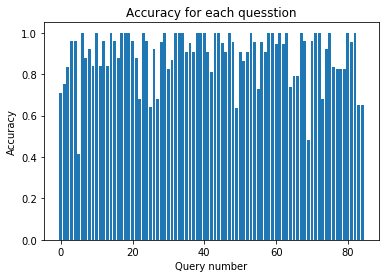

In [4]:
# for i in list(short_df['question_id'].unique()):
plt.figure()
plt.bar(np.linspace(0,len(accuracy_list)-1,len(accuracy_list)), accuracy_list)
plt.title("Accuracy for each quesstion")
plt.xlabel("Query number")
plt.ylabel("Accuracy")
plt.show()